[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/constanzacaride/Emergencias/blob/main/4PP7dias.ipynb)

##Pronóstico de precipitaciones acumuladas para los próximos 7 días

INPUTS: </br>
1- URL al archivo .zip con las imágenes de pronóstico de pp. (si no encuentra el de la fecha actual va buscando hacia atrás)  
2- Arg_IGN.kml (vector de polígonos de Argentina).  
3- Regiones_Arg.shp (vector de polígonos con las regiones de Argentina).   

OUTPUTS:  
1- Shapefile de polígonos con las clases (según rangos de pp) para toda Argentina.  
2- Shapefile de polígonos con las clases (según rangos de pp) para cada una de las regiones de Argentina.  

RESUMEN DE PASOS DEL SCRIPT:  
- Descarga el archivo zip del ftp de la NOAA.  
- Abre el archivo tiff.  
- Realiza un subset de la imagen dejando solo el área de interés (guarda el subset y el Bounding Box).  
- Transforma la información de raster a vector (se le aplican algoritmos de suavizado y de eliminación de polígonos pequeños).  
- Clasifica los valores de la imágen según rangos.  
- Asigna a cada polígono su número de clase.  
- Guarda un archivo shapefile con el pronóstico de precipitaciónes acumuladas en los próximos 7 días para toda Argentina.  
- Guarda un archivo shapefile con el pronóstico de precipitaciónes acumuladas en los próximos 7 días para cada una de las regiones de Argentina.  

Sitio de descarga https://ftp.cpc.ncep.noaa.gov/GIS/gfs_0.25/gfs_precip_shp_tif_20240815.zip  
Carpeta gfs_precip_shp_tif_20240815  
Archivo gfs_precip_gis_7day_20240815.tif

In [ ]:
#Instalo los paquetes que no están preinstaldos en colab.
!pip install shapelysmooth
!pip install libpysal
!pip install tqdm
!pip install rasterio
!pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
#Importo las librerias.
from urllib.request import urlretrieve
from zipfile import ZipFile
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime, timedelta
import requests
import numpy as np
from osgeo import osr, ogr, gdal, gdal_array
import matplotlib.pyplot as plt
from shapely.geometry import Point, shape, Polygon, MultiPolygon, LineString, MultiLineString
from shapelysmooth import chaikin_smooth
from shapely.ops import split
import fiona
from tqdm import tqdm
import libpysal
import rasterio as rio
import rasterstats
import subprocess
from rasterio.plot import reshape_as_raster, reshape_as_image

In [ ]:
#Hago la conexión al drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Defino la ruta (desde My Drive...) a la carpeta en la que se van a guardar los archivos de salida (la carpeta ya debe existir).
path_salidas = "/content/drive/MyDrive/" + input("/content/drive/MyDrive/ -> Escriba la carpeta o el path en el que va a trabajar: ")
print(path_salidas)

/content/drive/MyDrive/ -> Escriba la carpeta o el path en el que va a trabajar: Salidas
/content/drive/MyDrive/Salidas


In [ ]:
#Fecha actual.
hoy = datetime.today().strftime('%Y%m%d')
print(hoy)

20250117


In [ ]:
#Creo una carpeta salidas.
os.mkdir(path_salidas + '/PP'+ hoy)
path_pp = (path_salidas + '/PP'+ hoy)
print(path_pp)

/content/drive/MyDrive/Salidas/PP20250117


In [ ]:
#Creo un archivo que registre la fecha y hora de procesamiento.
fh = datetime.today() - timedelta(hours=3, minutes=0)
text_file = open(path_pp + '/0_Fecha-hora_procesamiento.txt', 'w')
my_string = str(fh)
text_file.write(my_string)
text_file.close()
print(fh)

2025-01-17 08:33:44.289340


In [ ]:
#Creo el path para descargar el archivo .zip con la información de pronóstico de precipitaciónes.
archivo_zipURL = "https://ftp.cpc.ncep.noaa.gov/GIS/gfs_0.25/gfs_precip_shp_tif_" + hoy  + ".zip"
archivo_zipURL

'https://ftp.cpc.ncep.noaa.gov/GIS/gfs_0.25/gfs_precip_shp_tif_20250117.zip'

In [ ]:
#Hago un pedido a la página web.
#Si no encuentra el archivo de la fecha de hoy busca la fecha inmediata anterior.
while True:
  R1 = requests.get(archivo_zipURL)
  Rstc = R1.status_code
  if Rstc == 404:
    u = archivo_zipURL[-6:-4]
    check1 = int(u)-1
    if check1 < 10:
      towrite = "0" + str(check1)
    else:
      towrite = str(check1)
    archivo_zipURL= archivo_zipURL[:-6] + towrite + archivo_zipURL[-4:]
  else:
    print("Conectado")
    break

Conectado


In [ ]:
#Descargo el archivo zip. (lo guardo en MyDrive y no en content x q es muy pesado - content solo acepta hasta 20M)
archivo_zip = path_pp + "/pp.zip"
urlretrieve(archivo_zipURL, archivo_zip)
print("Archivo descargado con EXITO!")

Archivo descargado con EXITO!


In [ ]:
#Descomprimo el archivo zip.
currentFileZip= ZipFile(archivo_zip)
currentFileZip.extractall(path_pp)
currentFileZip.close()
print("Archivo deszipeado")

Archivo deszipeado


In [ ]:
#Creo el path para abrir el archivo de mi interés.
path_w = path_pp + "/" + archivo_zipURL[-31:-4] + "/gfs_precip_gis_7day_" + archivo_zipURL[-12:-4] + ".tif"
print(path_w) #Acá, viendo el nombre, chequeo de qué día me bajó el archivo (si de hoy o de algún día anterior)

/content/drive/MyDrive/Salidas/PP20250117/gfs_precip_shp_tif_20250117/gfs_precip_gis_7day_20250117.tif


In [ ]:
#Abro el archivo tiff.
tifpp = gdal.Open(path_w)

In [ ]:
#Veo la metadata
tifpp.GetMetadata()

{'AREA_OR_POINT': 'Area',
 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)',
 'TIFFTAG_SOFTWARE': 'GrADS version 2.1.a2 ',
 'TIFFTAG_XRESOLUTION': '0.0076335883',
 'TIFFTAG_YRESOLUTION': '0.011789181'}

In [ ]:
#Obtengo el ancho y largo de la imágen.
img_width,img_height=tifpp.RasterXSize,tifpp.RasterYSize
print(img_width,img_height)

1441 721


In [ ]:
#Obtengo la información espacial de la imágen.
spdata = tifpp.GetGeoTransform()
#Salida...
#GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
#GT(1) w-e pixel resolution / pixel width.
#GT(2) row rotation (typically zero).
#GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
#GT(4) column rotation (typically zero).
#GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
print(spdata)

(-180.125, 0.25, 0.0, 90.125, 0.0, -0.25)


In [ ]:
#Registro la proyección de la imagen.
proj = tifpp.GetProjection()
proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [ ]:
#Paso la imagen a un array de numpy.
ppnp= tifpp.ReadAsArray()

In [ ]:
#Hago el subset y chequeo las dimensiones.
origxsubs = 400
finxsubs = 528
origysubs = 422
finysubs = 602
ppnp_s = ppnp[origysubs:finysubs, origxsubs:finxsubs]
ppnp_s.shape

(180, 128)

In [ ]:
#Info necesaria para volver a proyectar el subset con el Geotransforms.
#GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
#GT(1) w-e pixel resolution / pixel width.
#GT(2) row rotation (typically zero).
#GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
#GT(4) column rotation (typically zero).
#GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
ulxsubset = 0
ulysubset = 0
hemx = spdata[1] * origxsubs
ulxsubset = spdata[0] + hemx
hemy = spdata[5] * origysubs
ulysubset = spdata[3] + hemy

In [ ]:
#Coordenadas de las esquinas a partir del UL y tamaño de la imagen.
coordinates = [(ulxsubset, ulysubset), (ulxsubset+(spdata[1]*ppnp_s.shape[1]), ulysubset),
              (ulxsubset+(spdata[1]*ppnp_s.shape[1]), ulysubset+(spdata[5]*ppnp_s.shape[0])),
              (ulxsubset, ulysubset+(spdata[5]*ppnp_s.shape[0]))]
print(coordinates)

[(-80.125, -15.375), (-48.125, -15.375), (-48.125, -60.375), (-80.125, -60.375)]


In [ ]:
#Genero el bounding box del subset.
def create_polygon(coords, polygon_name):
#“”” Create a polygon from coordinates”””
 polygon = Polygon(coordinates)
 gdf = gpd.GeoDataFrame()
 gdf.loc[0,'name'] = polygon_name
 gdf.loc[0, 'geometry'] = polygon
 gdf = gdf.set_geometry('geometry')
 return gdf
shapefile = create_polygon(coordinates, 'BoundingBox')
#proj WGS84
shapefile.crs= proj #"+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
#Exporto el shapefile
bb = shapefile.to_file(path_pp + '/BB.shp')#, crs = 'EPSG:4326')

/usr/local/lib/python3.11/dist-packages/pandas/core/indexing.py:1880: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  self.obj[key] = construct_1d_array_from_inferred_fill_value(


In [ ]:
#Obtengo el valor min y max de la imagen. Primero defino el NaN
contNaN = 0
contMax = ppnp_s.max()
contMin = ppnp_s[ppnp_s!=contNaN].min()

In [ ]:
#Función para crear el GeoTiff a partir de un array de numpy
def create_geotiff(array, filename, geotransform, projection):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = array.shape
    dataset = driver.Create(filename, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geotransform)
    dataset.SetProjection(projection)
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()
    dataset = None

In [ ]:
#Defino la geotransform y la projección
geotransform = (ulxsubset, spdata[1], 0, ulysubset, 0, spdata[5])
projection = proj

In [ ]:
#Gaurdo el archivo como GeoTiff
path_s = path_pp + '/PP-subset.tif'
create_geotiff(ppnp_s, path_s , geotransform, projection)

In [ ]:
#Elimino el archivo .zip descargado y la carpeta generada a partir de este (elimino los archivos que tiene dentro primero porque debe estar vacía).
#Así libero espacio en disco (ya me queda la info original en el subset)
os.remove(path_pp + "/pp.zip")

carpeta = "/gfs_precip_shp_tif_" + hoy

dir = path_pp + carpeta
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

os.rmdir(path_pp + carpeta)

In [ ]:
#Abro el archivo Geotiff
tifpp_subs = gdal.Open(path_s)

In [ ]:
#Leo el Geotiff como GDALRasterBand
imgclass = tifpp_subs.GetRasterBand(1)

In [ ]:
#Defino la proyeccion del shp
shp_proj = osr.SpatialReference()
shp_proj.ImportFromWkt(proj)

0

In [ ]:
#Genero el shp vacio
output_file = "/content/pp-vector.shp"
call_drive = ogr.GetDriverByName("ESRI Shapefile")
create_shp = call_drive.CreateDataSource(output_file)
shp_layer = create_shp.CreateLayer("layername", srs = shp_proj)
#Genero dos columnas: una con el ID y otra con el valor de pp(mm)
new_field = ogr.FieldDefn("ID", ogr.OFTInteger) #OFTInteger, Simple 32bit integer
shp_layer.CreateField(new_field)
new_field = ogr.FieldDefn("value", ogr.OFTReal) #OFTReal, Double Precision floating point -> igual me los guarda como enteros :S
shp_layer.CreateField(new_field)

0

In [ ]:
#Hago el contour del raster
cont = gdal.ContourGenerate(imgclass, 0, 0, [10, 30, 60, 90, 120, 150, 180, 210, 240, 270], 0, 0, shp_layer, 0,  1)
create_shp.Destroy() #es necesario para que se guarde el archivo .shx y muestre el .shp, sino solo aparecen el .dbf y el .prj

In [ ]:
#Abro el shp de lineas (como un MultiLineString de shapely).
mls = MultiLineString([shape(line['geometry']) for line in fiona.open(output_file)])
elem = len(mls.geoms)

In [ ]:
#Aplico el algoritmo de suavizado
smoothed_lines = MultiLineString([chaikin_smooth(x) for x in mls.geoms])

In [ ]:
#Hago la lista de tuplas a partir del 'shapely.geometry.multilinestring.MultiLineString'.
mls_t = [tuple(x.coords) for x in list(smoothed_lines.geoms)]
elem2= len(mls_t)

In [ ]:
# Paso la lista de tuplas del MultiLineString a un geodataframe
# Lista de Dataframes que serán concatenados en un Dataframe mayor
pre_dfs = []

# Looping over all "rows" in `my_list`
for this_item in mls_t:
    # Generating a shapely geometry
    g = LineString(this_item)

    # Creating a single-row-DataFrame.
    this_df = pd.DataFrame({'geometry':[g]})

    # Appending this single-row-DataFrame to the `pre_dfs` list
    pre_dfs.append(this_df)

# Concatenating all the separate dataframes into one big DataFrame
single_df = pd.concat(pre_dfs, ignore_index=True).reset_index(drop=True)

# Finally, generating the actual GeoDataFrame that can be manipulated
line_gdf = gpd.GeoDataFrame(single_df,
                          geometry='geometry',
                          crs='epsg:4326')

In [ ]:
#Limpio el shp para que no haya "null geometry" (missing values + empty geometries) - Por las dudas, para que me funcione bien el rasterstats
line_gdf_fch = line_gdf[~(line_gdf['geometry'].is_empty | line_gdf['geometry'].isna())]

In [ ]:
#Abro el Bounding Box. (está en 4326)
poly_gdf = gpd.read_file(path_pp + '/BB.shp')

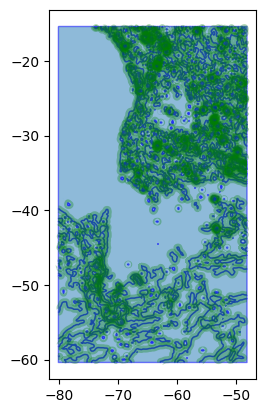

In [ ]:
#Corto el BB con las líneas (TARDA MUCHO, horas si hay muchas pp - mientras abajo cambie de "touches()" a "intersects()" o diga "Waiting to finish..." es que está corriendo)

# for each row in the dataset
for p_id, p_row in poly_gdf.iterrows():

    # prepare lists to control the splitting
    to_split = [p_row.geometry] # polygons that might be further split
    output = []                 # polygons that are fully split and ready to output

    # split the polygon and overwrite the geometry with the result
    while len (to_split) > 0:

        # get the next poly
        poly = to_split.pop()

        # get the lines that could split the current polygon
        lines = line_gdf_fch.loc[(line_gdf_fch.geometry.intersects(poly)) & (~line_gdf_fch.geometry.touches(poly))]

        # if there is splitting to do
        if len(lines.index) > 0:

            # split using the first available line
            split_polys = split(poly, lines.geometry.iloc[0])

            # add the resiulting polys to the list for further splitting if required
            to_split += [p for p in split_polys.geoms]

        # if there is no more splitting to do with this polygon, add it to the output
        else:
            output.append(poly)


    # overwrite the gdf with the new polygons
    poly_gdf = gpd.GeoDataFrame(geometry=output)

fig, ax = plt.subplots()
poly_gdf.plot(ax=ax, alpha=0.5, edgecolor='blue')
line_gdf.plot(ax=ax, color='green', alpha=0.3, lw=5)
plt.show()


In [ ]:
#Reproyectar el polígono a faja 3
poly_gdf = poly_gdf.set_crs('epsg:4326')
poly_gdf_f3 = poly_gdf.to_crs({'init':'epsg:5345'})

/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
#FUNCION para unir polígonos pequeños con sus vecinos
def merge_overlapping(gdf, merge_limit, overlap_limit, largest=None):
    """Merge overlapping polygons based on a set of conditions.

    Overlapping polygons smaller than ``merge_limit`` are merged to a neighboring polygon.
    If ``largest=None`` it picks one randomly, otherwise it picks the largest (True) or the
    smallest (False).

    Polygons larger than ``merge_limit`` are merged to neighboring if they share area larger
    than ``area * overlap_limit``.

    Parameters
    ----------
    gdf : GeoDataFrame
        GeoDataFrame with polygon or mutli polygon geometry
    merge_limit : float
        area of overlapping polygons that are to be merged with neighbors no matter the size
        of the overlap TAMAÑO DE LOS POLIGOMOS A FUSIONAR (selección)}
    overlap_limit : float (0-1)
        ratio of area of an overlapping polygon that has to be shared with other polygon
        to merge both into a one SUPNGO QUE SI ES 0 LO UNE AUNQUE NO SE SUPERPONGAN!
    largest : bool (default None)
        Merge each overlapping polygons smaller than merge_limit with its largest (True), or smallest (False) neighbor.
        If None, merge with any neighbor non-deterministically but performantly.

    Returns
    -------

    GeoDataFrame
    """
    neighbors = {}
    for i, poly in tqdm(gdf.geometry.items(), total=len(gdf)):
        hits = gdf.sindex.query(poly, predicate='intersects')
        hits = hits[hits != i]

        if hits.size == 0:
            neighbors[i] = []
            continue

        if poly.area < merge_limit:
            if hits.size == 0:
                neighbors[i] = list(hits)
            else:
                if largest is None:
                    neighbors[i] = [hits[0]]
                else:
                    sub = gdf.geometry.iloc[hits]
                    inters = sub.intersection(poly.exterior)
                    if largest:
                        neighbors[i] = [inters.length.idxmax()]
                    else:
                        neighbors[i] = [inters.length.idxmin()]
        else:
            sub = gdf.geometry.iloc[hits]
            inters = sub.intersection(poly)
            include = sub.index[inters.area > (sub.area * overlap_limit)]
            neighbors[i] = list(include)

    W = libpysal.weights.W(neighbors, silence_warnings=True)
    return gdf.dissolve(W.component_labels)

In [ ]:
#Aplico funcion de fusión (se une al polígono vecino más grande)
poly_gdf_f3f = merge_overlapping(poly_gdf_f3, 400000000, 0, largest=True)

100%|██████████| 922/922 [00:15<00:00, 60.63it/s]


In [ ]:
#Reproyecto a WGS y exporto a shp
poly_gdf_f = poly_gdf_f3f.to_crs({'init':'epsg:4326'})
print(poly_gdf_f.crs)
poly_gdf_f.to_file('/content/poli_fusionado.shp')

/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


+init=epsg:4326 +type=crs


In [ ]:
#Limpio el shp para que no haya "null geometry" (missing values + empty geometries) - Para que me funcione bien el rasterstats
poly_gdf_fch = poly_gdf_f[~(poly_gdf_f['geometry'].is_empty | poly_gdf_f['geometry'].isna())]

In [ ]:
#Reclasifico los valores para pasar la info al shp
ppnp_S[(ppnp_S >= 0) & (ppnp_S < 10)] = 0
ppnp_S[(ppnp_S >= 10) & (ppnp_S < 30)] = 1
ppnp_S[(ppnp_S >= 30) & (ppnp_S < 60)] = 2
ppnp_S[(ppnp_S >= 60) & (ppnp_S < 90)] = 3
ppnp_S[(ppnp_S >= 90) & (ppnp_S < 120)] = 4
ppnp_S[(ppnp_S >= 120) & (ppnp_S < 150)] = 5
ppnp_S[(ppnp_S >= 150) & (ppnp_S < 180)] = 6
ppnp_S[(ppnp_S >= 180) & (ppnp_S < 210)] = 7
ppnp_S[(ppnp_S >= 210) & (ppnp_S < 240)] = 8
ppnp_S[(ppnp_S >= 240) & (ppnp_S < 270)] = 9
ppnp_S[(ppnp_S >= 270)] = 10
#srcband_S[0]

In [ ]:
#Salida... GDAL-style geotransforms
#GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
#GT(1) w-e pixel resolution / pixel width.
#GT(2) row rotation (typically zero).
#GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
#GT(4) column rotation (typically zero).
#GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
#=> transform = [244300.61494985913, 25.52514657450613, 0.0, 1000868.7876863468, 0.0, -25.52514657450613]
#Salida... Rasterio-style... debería ser pix rot coord-x pix rot coord-y (25.52514657450613, 0.0, 244300.61494985913, 0.0, -25.52514657450613, 1000868.7876863468)
from affine import Affine
aff = Affine.from_gdal(*geotransform)

In [ ]:
#Moda del raster por polígono
moda = rasterstats.zonal_stats(poly_gdf_fch, ppnp_S, affine = aff, stats = "majority")

/usr/local/lib/python3.11/dist-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [ ]:
#Adjunto las estadisticas al gdf
df = pd.DataFrame(moda)
df = pd.concat([df, poly_gdf_fch], axis=1)
gdf = gpd.GeoDataFrame(df, geometry=df.geometry)

In [ ]:
#Puedo traer archivos que tenga en algún repositorio de github (para subirlos al git deben ser más chicos de 25M)
#Buscar la dirección .git del repositorio (ver imágen debajo)
#Una vez corrida la sentencia el repositorio se clona en la carpeta contenidos (ver la tabla de contenidos a la izquierda)
!git clone "https://github.com/constanzacaride/Emergencias.git"

Cloning into 'Emergencias'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 65 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 26.52 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (17/17), done.


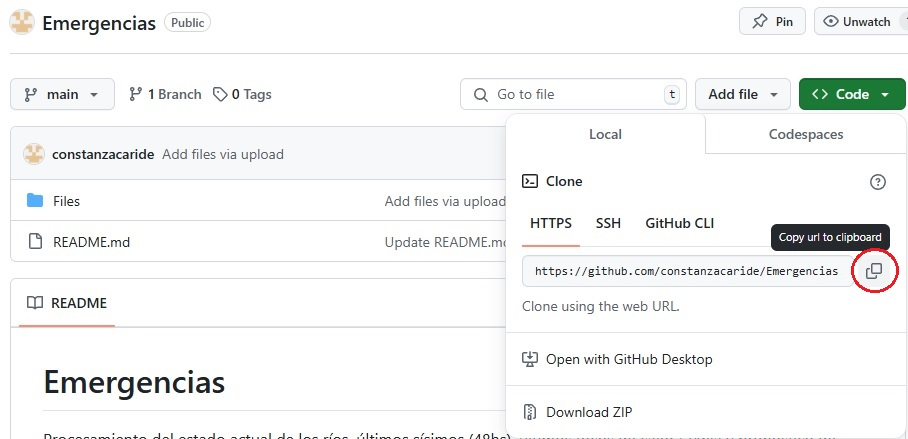

In [ ]:
#Descomprimo el archivo zip
currentFileZip= ZipFile("/content/Emergencias/Files/Regiones_Arg.zip") #El archivo está en formato shp
currentFileZip.extractall("/content/")
currentFileZip.close()
print("Archivo deszipeado")

Archivo deszipeado


In [ ]:
#Abro el .shp de Regiones
Reg = gpd.read_file("/content/Regiones_Arg.shp", encoding='utf-8')

In [ ]:
#Hago un clip de Arg
pparg = gpd.clip(gdf, Reg)

<ipython-input-70-7844c0cd02b8>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  pparg = gpd.clip(gdf, Reg)


In [ ]:
#Guardo el shp de salida de pp de Argentina.
pparg.to_file(path_pp + '/PP_Arg.shp')#, crs = {'init' :'epsg:4326'})

In [ ]:
#Hago el clip y guardo los .shp de salida de pp de las regiones de Argentina.
for i, poly in tqdm(Reg.geometry.items(), total=len(Reg)):
  x = gpd.clip(gdf, poly)
  x.to_file(filename= path_pp + "/PP" + Reg['Region'][i] + ".shp")

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


###Fuentes de código (Ago-24)
- Contour del raster: https://hatarilabs.com/ih-en/how-to-convert-a-raster-to-contours-with-python-and-gdal-tutorial  
- Abrir el shp de lineas como un MultiLineString de shapely: https://stackoverflow.com/questions/30429913/python-getting-attributes-from-line-contained-in-a-multilinestring-shapefile-t  
- Algoritmo de suavizado: https://pypi.org/project/shapelysmooth/  
- Generar la lista de tuplas a partir del 'shapely.geometry.multilinestring.MultiLineString': https://gis.stackexchange.com/questions/319295/how-to-reverse-the-multilinestring-command-to-a-list-of-arrays, https://gis.stackexchange.com/questions/456266/error-of-multilinestring-object-is-not-iterable  
- Limpiar el shp para que no haya "null geometry" (missing values + empty geometries): https://gis.stackexchange.com/questions/421764/unable-to-perform-zonal-stats-in-python-because-of-attribute-error  
- Unir polígonos pequeños al vecino más grande: https://github.com/sjsrey/geoplanar/issues/36 (al original hay que cambiarle, en la 2da linea, "iteritems" por "items" para que lo tome bien).  
- Cálculo de la moda del raster: https://www.youtube.com/watch?v=VIr-pejky6E , https://pythonhosted.org/rasterstats/manual.html#zonal-statistics  
- Adjuntar las estadísticas al gdf: https://gis.stackexchange.com/questions/421764/unable-to-perform-zonal-stats-in-python-because-of-attribute-error